In [276]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
from matplotlib import gridspec

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import scipy as sp

import lib

# Извлечение данных и отбор выборки

In [277]:
import library

dataset = library.creat_dataset()
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [278]:
data = dataset.loc[dataset['id'] == 0]
data = data[['attitude.roll', 'attitude.pitch', 'attitude.yaw','act']]

/home/apxapa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


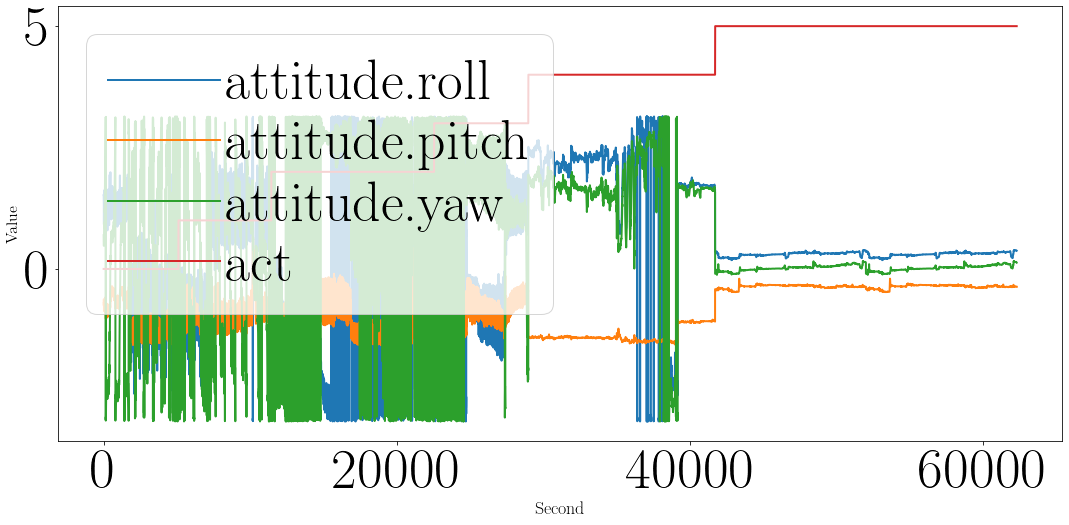

In [279]:
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
lgnd=plt.legend()
fig = pyplt.gcf()
fig.set_size_inches(18, 8)
plt.show()

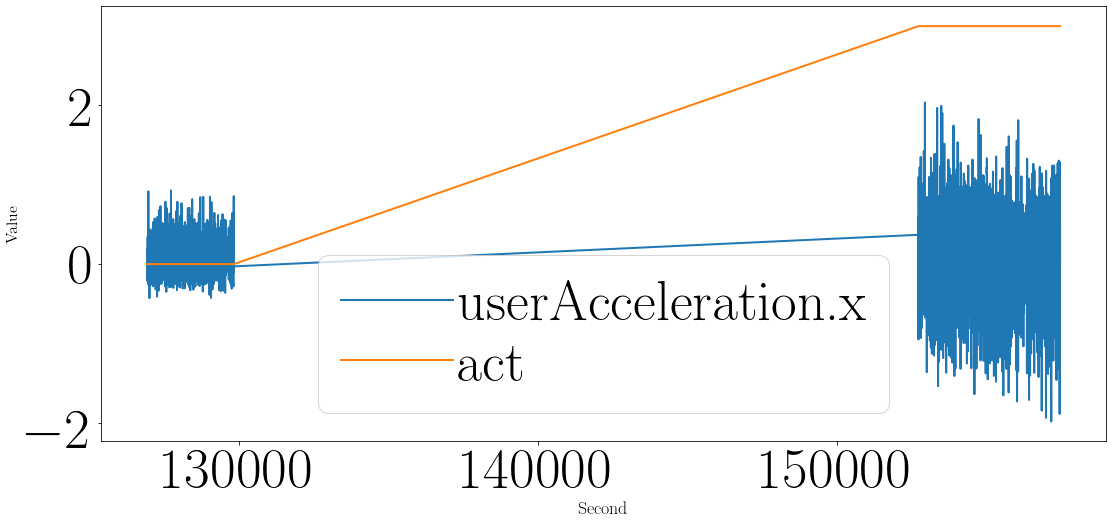

In [366]:
data = dataset.loc[dataset['id'] == 2].loc[(dataset['trial'] == 2)|(dataset['trial'] == 9)]
data = data[['userAcceleration.x','act']] 

T = 100
K = 2
discrete = T//10

# series_name = '2_patern'

X_test = data.values[:4300, 0].reshape([1,-1,1])
List_of_x = np.arange(T, X_test[0].shape[0] - 2*T)

library.drow_data_multi(data)

# Кластеризация

In [367]:
phase_track = lib.return_phase_track(X_test, T)

# компоненты в точках T,T+discrete.. max-T-discrete
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis(phase_track, T = T,                                                                                        discrete = discrete)

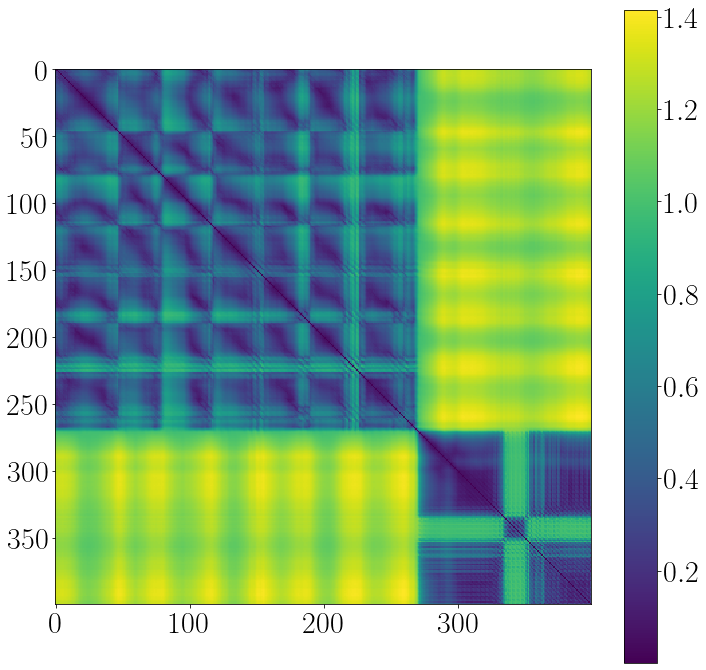

In [368]:
M_pairwise = lib.get_pairwise_matrix(List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c)
library.drow_matrix_cor(M_pairwise)

In [369]:
model = AgglomerativeClustering(n_clusters=K, affinity='precomputed', linkage='complete')

fitted = model.fit(M_pairwise)
prediction_vector = fitted.fit_predict(M_pairwise)
prediction_vector = np.asarray([[x]*(discrete) for x in prediction_vector]).reshape(-1)

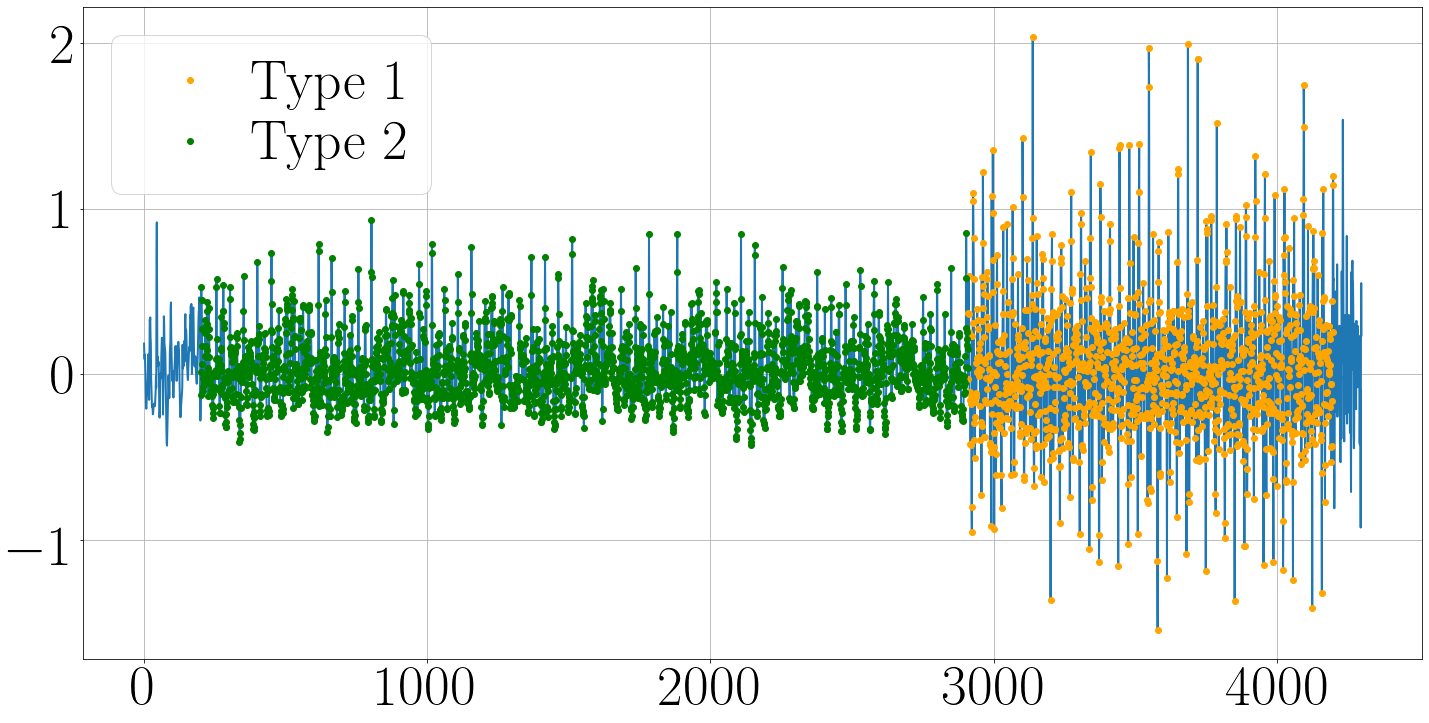

In [370]:


library.drow_data_cluster(X_test, prediction_vector, List_of_x, M_pairwise, T)

In [371]:
List_of_All, List_of_point = lib.segmentation(X_test[:, 2*T:X_test[0].shape[0]-T, :], prediction_vector, T)

In [372]:
X_test = data.values[:4300, 0]
t = np.arange(len(X_test))

x_new = lib.normalizer(X_test, t, t.shape[0])

X_test = np.reshape(x_new, [1,-1,1])

In [373]:
# phase track
phase_track = lib.return_phase_track(X_test, T)

# basis vector
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis(phase_track, T = T,
                                                                                      discrete = discrete)

# pairwise matrix
M_pairwise = lib.get_pairwise_matrix(List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c)

# clustering
model = AgglomerativeClustering(n_clusters=K, affinity='precomputed', linkage='complete')
fitted = model.fit(M_pairwise)
prediction_vector = fitted.fit_predict(M_pairwise)
prediction_vector = np.asarray([[x]*(discrete) for x in prediction_vector]).reshape(-1)

# 2 dimentions projection
embedding = MDS(n_components=2, dissimilarity='precomputed')
resss = embedding.fit_transform(M_pairwise)

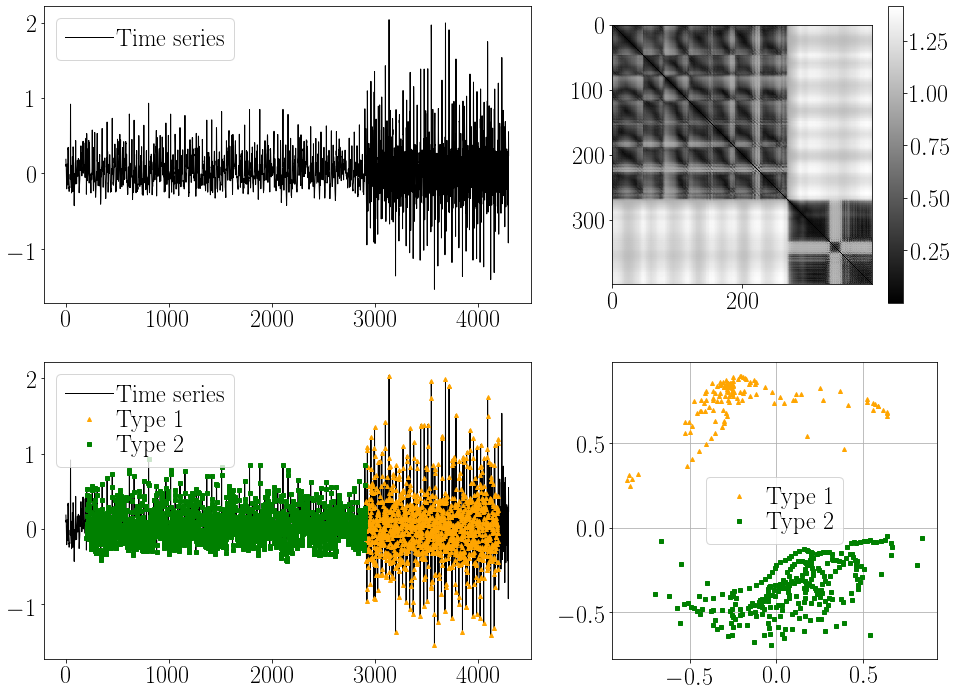

In [374]:
import imp
imp.reload(library)

library.drow_big(X_test, M_pairwise, prediction_vector, T, resss, discrete)

# Сегментация

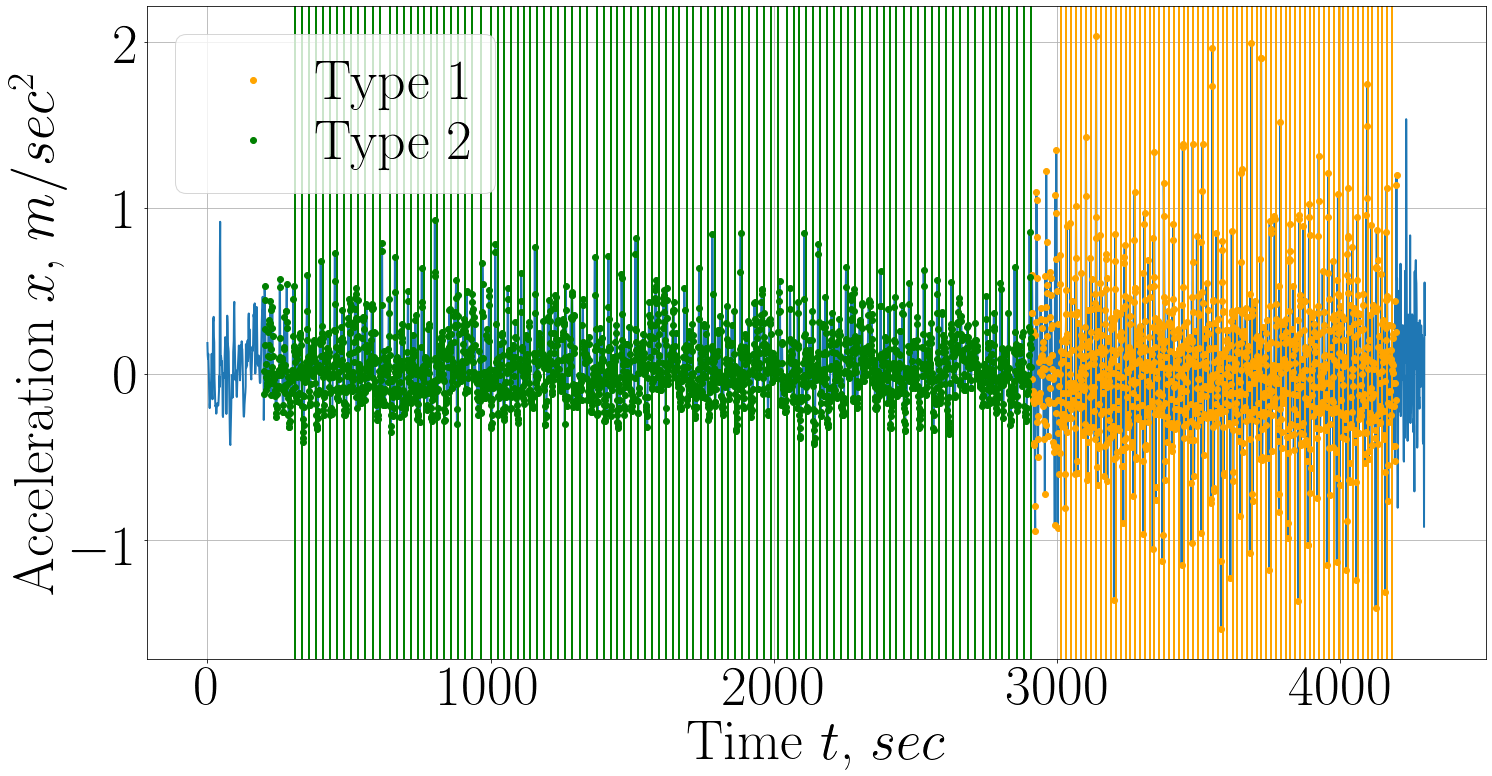

In [375]:
List_of_All, List_of_point = lib.segmentation(X_test[:, 2*T:X_test[0].shape[0]-T, :], prediction_vector, T)

library.drow_with_segments(X_test, List_of_All, List_of_point, prediction_vector, T, List_of_x)

In [376]:
List_of_ = (List_of_x + T)[List_of_point[1] + T]
i

array([ 311,  335,  359,  383,  407,  432,  457,  481,  506,  531,  556,
        583,  610,  645,  670,  695,  718,  742,  765,  788,  812,  836,
        860,  884,  909,  935,  966, 1000, 1025, 1049, 1072, 1095, 1117,
       1140, 1164, 1188, 1212, 1237, 1262, 1289, 1315, 1340, 1376, 1401,
       1425, 1448, 1472, 1496, 1520, 1544, 1569, 1593, 1618, 1643, 1666,
       1693, 1713, 1742, 1766, 1791, 1816, 1840, 1864, 1889, 1913, 1939,
       1964, 1990, 2016, 2048, 2070, 2089, 2114, 2139, 2163, 2188, 2212,
       2236, 2261, 2286, 2311, 2338, 2364, 2388, 2409, 2433, 2458, 2483,
       2508, 2534, 2559, 2585, 2609, 2634, 2659, 2684, 2711, 2738, 2764,
       2783, 2807, 2832, 2857, 2882, 2908])

In [447]:
X_test = X_test.reshape(-1)
pack_segments = []
for k in range(len(List_of_point)):  
    pack_segments_k = []
    for i in range(len(List_of_point[k])-1):
        left = (List_of_x + T)[List_of_point[k] + T][i]
        right = (List_of_x + T)[List_of_point[k] + T][i+1]
        pack_segments_k.append(X_test[left:right])
    pack_segments.append(pack_segments_k)

In [465]:
segments = pack_segments[0]+pack_segments[1]

In [466]:
t_size = 20
t = np.arange(len(segments[0]))
segments = lib.normalizer(segments[1], t, t.shape[0])
segments

ValueError: x and y arrays must be equal in length along interpolation axis.

In [452]:
#Коэффициенты фурье
from numpy.fft import rfft, rfftfreq
spectrum = []
for i in range(len(segments)):
    rfftt = rfft(segments[i])
    spectrum.append(rfftt)

In [455]:
segments[2]

array([-0.074682,  0.362377,  0.437263,  0.142205, -0.178778, -0.163035,
       -0.105858, -0.055748, -0.159303, -0.171752, -0.055808, -0.069749,
       -0.605927, -0.32456 ,  0.577081, -0.184628,  0.357964])